# 1. From Posts(=submissions) to Networks

The goal of this section is to break-down a dataframe full of submissions, into a network. We will then visualize this network.
The overall steps are:
- Load the dataframe.
- Filter rows that contain interactions, i.e., commenting events.
- Generating an edgelist, then use it to generate a network object.
- Visualize network

# Install dependencies and import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Tutorial_2'

/content/drive/MyDrive/Tutorial_2


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import nltk

import datetime

# Read dataframe
We will use three files:  
(1) datascience-new-comment.csv: contains information on comments  
(2) datascience-new-submission.csv: contains information on submissions  
(3) datascience-user-data.csv: contains information on users

In [49]:
url = "https://raw.githubusercontent.com/EunCheolChoi0123/COMM557Tutorial/refs/heads/main/Tutorial%203%20Reddit%20Scraper%20and%20Network"
comments_df = pd.read_csv(url + "/datascience-new-comment.csv")
# comments_df = pd.read_csv("./datascience-new-comment.csv")
comments_df.columns

Index(['id', 'parent_id', 'submission_id', 'author', 'created_utc', 'body',
       'score', 'permalink', 'is_submitter', 'subreddit'],
      dtype='object')

In [50]:
# 'created_utc' column contains Unix timestamp.
# This format tells us how many seconds have past since 1970-01-01 00:00:00
# Quite impressive (and actually practical), but not straightforward for us humans.
# Let's transforme those into YYYY-mm-dd hh:mm:ss format and save them in another column.

comments_df['created_utc_datetime'] = pd.to_datetime(comments_df['created_utc'], unit='s')
comments_df

,id,parent_id,submission_id,author,created_utc,body,score,permalink,is_submitter,subreddit,created_utc_datetime
0,ndlnhyf,t3_1ne37bs,1ne37bs,vornamemitd,1.757579e+09,This one will give you a solid starting point ...,5,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:29:40
1,ndln0cp,t3_1ne37bs,1ne37bs,mydogismylawyer,1.757579e+09,I’m an MCA student who just started this Septe...,-6,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:24:42
2,ndls0gr,t1_ndlnhyf,1ne37bs,ciaoshescu,1.757582e+09,"Oh yeah, that's a really good collection. It's...",1,/r/datascience/comments/1ne37bs/looking_for_re...,True,datascience,2025-09-11 09:14:17
3,ndloszo,t1_ndln0cp,1ne37bs,fightitdude,1.757580e+09,There is a dedicated thread you can use for th...,1,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:42:53
4,ndlq8po,t1_ndloszo,1ne37bs,mydogismylawyer,1.757581e+09,Thanks,1,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:56:49
...,...,...,...,...,...,...,...,...,...,...,...
104,ncvfw2e,t1_nctss1z,1na6x3q,Rockingtits,1.757234e+09,"Thanks, this is good advice",1,/r/datascience/comments/1na6x3q/help_me_evalua...,True,datascience,2025-09-07 08:26:19
105,nd1pxjy,t1_ncy1noa,1na6x3q,Rockingtits,1.757316e+09,"I'd say hindrance. The data we have is OK, the...",2,/r/datascience/comments/1na6x3q/help_me_evalua...,True,datascience,2025-09-08 07:27:16
106,ncs0pbc,t1_ncrvaor,1na6x3q,Rockingtits,1.757185e+09,"Thanks, why?",2,/r/datascience/comments/1na6x3q/help_me_evalua...,True,datascience,2025-09-06 18:59:47
107,ncscx0m,t1_ncsckyg,1na6x3q,Single_Vacation427,1.757189e+09,"Once you go into consultancy, it's very diffic...",2,/r/datascience/comments/1na6x3q/help_me_evalua...,False,datascience,2025-09-06 20:03:13


# Short-hand Pandas Filters


#### First, we filter comments that are under other comments, and are made at a specific date.  
In this case, 'parent_id' attribute starts with t1.

In [51]:
## | is short-hand for OR ; & is short-hand for AND
today = datetime.datetime(2024, 9, 11)

comments_to_comments_df = comments_df[(comments_df.parent_id.str.startswith('t1')) & (comments_df.created_utc_datetime >= today)]
comments_to_comments_df

,id,parent_id,submission_id,author,created_utc,body,score,permalink,is_submitter,subreddit,created_utc_datetime
2,ndls0gr,t1_ndlnhyf,1ne37bs,ciaoshescu,1.757582e+09,"Oh yeah, that's a really good collection. It's...",1,/r/datascience/comments/1ne37bs/looking_for_re...,True,datascience,2025-09-11 09:14:17
3,ndloszo,t1_ndln0cp,1ne37bs,fightitdude,1.757580e+09,There is a dedicated thread you can use for th...,1,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:42:53
4,ndlq8po,t1_ndloszo,1ne37bs,mydogismylawyer,1.757581e+09,Thanks,1,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:56:49
15,ndadufe,t1_nda7b5y,1ncmcgf,TserriednichThe4th,1.757435e+09,If you need to color outside the lines in pyto...,17,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 16:19:24
16,ndac9mx,t1_ndabntw,1ncmcgf,Factitious_Character,1.757434e+09,Not really. I used pytorch in a previous proje...,5,/r/datascience/comments/1ncmcgf/pytorch_lightn...,True,datascience,2025-09-09 16:11:47
17,ndfcz0o,t1_ndegke7,1ncmcgf,Factitious_Character,1.757502e+09,"In my opinion, not much. But he is more experi...",1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,True,datascience,2025-09-10 11:08:11
18,ndc2f5r,t1_ndb8xwf,1ncmcgf,WingedTorch,1.757452e+09,lol,5,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 21:06:10
19,ndax2f0,t1_ndadufe,1ncmcgf,Accurate-Usual8839,1.757440e+09,"You can, but it'll be harder than just using r...",3,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 17:50:04
20,ndfrwi9,t1_ndfcz0o,1ncmcgf,venustrapsflies,1.757508e+09,I would generally say it is preferable to use ...,1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-10 12:44:34
21,ndb87r9,t1_ndax2f0,1ncmcgf,TserriednichThe4th,1.757443e+09,When I used pytorch lightning for my custom mo...,3,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 18:43:01


#### Next, we filter comments that are directly below submissions, and are made at a specific date (today).
In this case, 'parent_id' attribute starts with t3.

In [52]:
## | is short-hand for OR ; & is short-hand for AND
comments_to_submissions_df = comments_df[(comments_df.parent_id.str.startswith('t3') & (comments_df.created_utc_datetime >= today) & (comments_df.is_submitter == False))]
comments_to_submissions_df

,id,parent_id,submission_id,author,created_utc,body,score,permalink,is_submitter,subreddit,created_utc_datetime
0,ndlnhyf,t3_1ne37bs,1ne37bs,vornamemitd,1.757579e+09,This one will give you a solid starting point ...,5,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:29:40
1,ndln0cp,t3_1ne37bs,1ne37bs,mydogismylawyer,1.757579e+09,I’m an MCA student who just started this Septe...,-6,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:24:42
5,ndlk5b2,t3_1ne1d5t,1ne1d5t,QianLu,1.757577e+09,I've definitely been looped in way too late an...,1,/r/datascience/comments/1ne1d5t/collaborating_...,False,datascience,2025-09-11 07:56:08
6,nda7b5y,t3_1ncmcgf,1ncmcgf,Accurate-Usual8839,1.757433e+09,Stupid colleague. Lightning is fine. Pytorch i...,75,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 15:48:12
7,ndabntw,t3_1ncmcgf,1ncmcgf,koolaidman123,1.757434e+09,does your workplace use pytorch lightning by d...,18,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 16:08:49
8,ndbibmf,t3_1ncmcgf,1ncmcgf,lakeland_nz,1.757446e+09,I think your colleague went too far but they d...,7,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 19:31:41
9,ndc5edp,t3_1ncmcgf,1ncmcgf,Drakkur,1.757453e+09,Post PyTorch 2.0 is relatively easy and it bec...,7,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 21:21:10
10,ndegke7,t3_1ncmcgf,1ncmcgf,Jorrissss,1.757484e+09,"How much heavy lifting is ""criticized"" doing? ...",1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-10 06:05:23
11,ndfr82h,t3_1ncmcgf,1ncmcgf,codechisel,1.757508e+09,Sounds like he's using you to brag about his k...,1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-10 12:40:40
12,ndjpl9b,t3_1ncmcgf,1ncmcgf,telperion101,1.757549e+09,You know context is everything. We often confl...,1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-11 00:05:37


### We want to make edgelists.  
When comments are made below comments, they create a link in this case.  
Thus, 'source' is a comment under 'target' comment.

In [53]:
submission_df = pd.read_csv(url + '/datascience-new-submission.csv')
# submission_df = pd.read_csv('./datascience-new-submission.csv')

In [54]:
# This dataframe shows who made 'source' comments, and the 'target' comments' ids

df1 = comments_to_comments_df[['author', 'parent_id', 'body']].copy()
df1['parent_id'] = df1['parent_id'].str.split('_').str[-1]
df1.columns = ['comment_to_comment_author', 'comment_id', 'comment_body']
df1

,comment_to_comment_author,comment_id,comment_body
2,ciaoshescu,ndlnhyf,"Oh yeah, that's a really good collection. It's..."
3,fightitdude,ndln0cp,There is a dedicated thread you can use for th...
4,mydogismylawyer,ndloszo,Thanks
15,TserriednichThe4th,nda7b5y,If you need to color outside the lines in pyto...
16,Factitious_Character,ndabntw,Not really. I used pytorch in a previous proje...
17,Factitious_Character,ndegke7,"In my opinion, not much. But he is more experi..."
18,WingedTorch,ndb8xwf,lol
19,Accurate-Usual8839,ndadufe,"You can, but it'll be harder than just using r..."
20,venustrapsflies,ndfcz0o,I would generally say it is preferable to use ...
21,TserriednichThe4th,ndax2f0,When I used pytorch lightning for my custom mo...


In [55]:
# This dataframe shows who made 'target' comments, and the 'target' comments' ids

df2 = comments_to_comments_df[['author', 'id']]
df2.columns = ['comment_author', 'comment_id']
df2

,comment_author,comment_id
2,ciaoshescu,ndls0gr
3,fightitdude,ndloszo
4,mydogismylawyer,ndlq8po
15,TserriednichThe4th,ndadufe
16,Factitious_Character,ndac9mx
17,Factitious_Character,ndfcz0o
18,WingedTorch,ndc2f5r
19,Accurate-Usual8839,ndax2f0
20,venustrapsflies,ndfrwi9
21,TserriednichThe4th,ndb87r9


In [56]:
# merging two dataframe by inner join makes edgelists

df = df1.merge(df2, how='inner', on='comment_id')
df

,comment_to_comment_author,comment_id,comment_body,comment_author
0,mydogismylawyer,ndloszo,Thanks,fightitdude
1,Accurate-Usual8839,ndadufe,"You can, but it'll be harder than just using r...",TserriednichThe4th
2,venustrapsflies,ndfcz0o,I would generally say it is preferable to use ...,Factitious_Character
3,TserriednichThe4th,ndax2f0,When I used pytorch lightning for my custom mo...,Accurate-Usual8839
4,vonWitzleben,nd862gt,"Sure, but did you scrape them manually off of ...",bingbong_sempai
5,CIA-chat-bot,ndcgkha,"Yes, DM me your GitHub username.",bingbong_sempai
6,bingbong_sempai,nd86ykw,Yeah I had to scrape the data manually. That w...,vonWitzleben
7,bingbong_sempai,ndclfoa,It's bingbong-sempai :D,CIA-chat-bot
8,fenrirbatdorf,nd7pf55,"Gotcha, I think someone else at some point tol...",EstablishmentHead569
9,Bayesian1701,ndfq047,This is super helpful. I’ve heard of the stati...,NerdyMcDataNerd


In [57]:
comments_network_df = df[['comment_to_comment_author', 'comment_author', 'comment_body']]
comments_network_df.columns = ['source', 'target', 'comment']
comments_network_df

,source,target,comment
0,mydogismylawyer,fightitdude,Thanks
1,Accurate-Usual8839,TserriednichThe4th,"You can, but it'll be harder than just using r..."
2,venustrapsflies,Factitious_Character,I would generally say it is preferable to use ...
3,TserriednichThe4th,Accurate-Usual8839,When I used pytorch lightning for my custom mo...
4,vonWitzleben,bingbong_sempai,"Sure, but did you scrape them manually off of ..."
5,CIA-chat-bot,bingbong_sempai,"Yes, DM me your GitHub username."
6,bingbong_sempai,vonWitzleben,Yeah I had to scrape the data manually. That w...
7,bingbong_sempai,CIA-chat-bot,It's bingbong-sempai :D
8,fenrirbatdorf,EstablishmentHead569,"Gotcha, I think someone else at some point tol..."
9,Bayesian1701,NerdyMcDataNerd,This is super helpful. I’ve heard of the stati...


Also, when comments are made below submissions(=posts), they create a link in this case.  
Thus, 'source' is a comment under a 'target' post.

In [58]:
comments_to_submissions_df

,id,parent_id,submission_id,author,created_utc,body,score,permalink,is_submitter,subreddit,created_utc_datetime
0,ndlnhyf,t3_1ne37bs,1ne37bs,vornamemitd,1.757579e+09,This one will give you a solid starting point ...,5,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:29:40
1,ndln0cp,t3_1ne37bs,1ne37bs,mydogismylawyer,1.757579e+09,I’m an MCA student who just started this Septe...,-6,/r/datascience/comments/1ne37bs/looking_for_re...,False,datascience,2025-09-11 08:24:42
5,ndlk5b2,t3_1ne1d5t,1ne1d5t,QianLu,1.757577e+09,I've definitely been looped in way too late an...,1,/r/datascience/comments/1ne1d5t/collaborating_...,False,datascience,2025-09-11 07:56:08
6,nda7b5y,t3_1ncmcgf,1ncmcgf,Accurate-Usual8839,1.757433e+09,Stupid colleague. Lightning is fine. Pytorch i...,75,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 15:48:12
7,ndabntw,t3_1ncmcgf,1ncmcgf,koolaidman123,1.757434e+09,does your workplace use pytorch lightning by d...,18,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 16:08:49
8,ndbibmf,t3_1ncmcgf,1ncmcgf,lakeland_nz,1.757446e+09,I think your colleague went too far but they d...,7,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 19:31:41
9,ndc5edp,t3_1ncmcgf,1ncmcgf,Drakkur,1.757453e+09,Post PyTorch 2.0 is relatively easy and it bec...,7,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-09 21:21:10
10,ndegke7,t3_1ncmcgf,1ncmcgf,Jorrissss,1.757484e+09,"How much heavy lifting is ""criticized"" doing? ...",1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-10 06:05:23
11,ndfr82h,t3_1ncmcgf,1ncmcgf,codechisel,1.757508e+09,Sounds like he's using you to brag about his k...,1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-10 12:40:40
12,ndjpl9b,t3_1ncmcgf,1ncmcgf,telperion101,1.757549e+09,You know context is everything. We often confl...,1,/r/datascience/comments/1ncmcgf/pytorch_lightn...,False,datascience,2025-09-11 00:05:37


In [59]:
df3 = comments_to_submissions_df[['author', 'body', 'submission_id']].copy()
df3.columns = ['comment_author', 'comment_body', 'submission_id']
df3

,comment_author,comment_body,submission_id
0,vornamemitd,This one will give you a solid starting point ...,1ne37bs
1,mydogismylawyer,I’m an MCA student who just started this Septe...,1ne37bs
5,QianLu,I've definitely been looped in way too late an...,1ne1d5t
6,Accurate-Usual8839,Stupid colleague. Lightning is fine. Pytorch i...,1ncmcgf
7,koolaidman123,does your workplace use pytorch lightning by d...,1ncmcgf
8,lakeland_nz,I think your colleague went too far but they d...,1ncmcgf
9,Drakkur,Post PyTorch 2.0 is relatively easy and it bec...,1ncmcgf
10,Jorrissss,"How much heavy lifting is ""criticized"" doing? ...",1ncmcgf
11,codechisel,Sounds like he's using you to brag about his k...,1ncmcgf
12,telperion101,You know context is everything. We often confl...,1ncmcgf


In [60]:
df4 = submission_df[['author', 'id']]
df4.columns = ['submission_author', 'submission_id']
df4

,submission_author,submission_id
0,ciaoshescu,1ne37bs
1,ButtFlannel69,1ne1d5t
2,ThomasAger,1nd94cy
3,Factitious_Character,1ncmcgf
4,bingbong_sempai,1nc93qq
5,samushusband,1nbxzs0
6,AutoModerator,1nbdtct
7,mutlu_simsek,1naptuq
8,metalvendetta,1nac35j
9,Rockingtits,1na6x3q


In [61]:
df = df3.merge(df4, how='inner', on='submission_id')
df

,comment_author,comment_body,submission_id,submission_author
0,vornamemitd,This one will give you a solid starting point ...,1ne37bs,ciaoshescu
1,mydogismylawyer,I’m an MCA student who just started this Septe...,1ne37bs,ciaoshescu
2,QianLu,I've definitely been looped in way too late an...,1ne1d5t,ButtFlannel69
3,Accurate-Usual8839,Stupid colleague. Lightning is fine. Pytorch i...,1ncmcgf,Factitious_Character
4,koolaidman123,does your workplace use pytorch lightning by d...,1ncmcgf,Factitious_Character
5,lakeland_nz,I think your colleague went too far but they d...,1ncmcgf,Factitious_Character
6,Drakkur,Post PyTorch 2.0 is relatively easy and it bec...,1ncmcgf,Factitious_Character
7,Jorrissss,"How much heavy lifting is ""criticized"" doing? ...",1ncmcgf,Factitious_Character
8,codechisel,Sounds like he's using you to brag about his k...,1ncmcgf,Factitious_Character
9,telperion101,You know context is everything. We often confl...,1ncmcgf,Factitious_Character


In [62]:
sub_com_network_df = df[['comment_author', 'submission_author', 'comment_body']]
sub_com_network_df.columns = ['source', 'target', 'comment']
sub_com_network_df

,source,target,comment
0,vornamemitd,ciaoshescu,This one will give you a solid starting point ...
1,mydogismylawyer,ciaoshescu,I’m an MCA student who just started this Septe...
2,QianLu,ButtFlannel69,I've definitely been looped in way too late an...
3,Accurate-Usual8839,Factitious_Character,Stupid colleague. Lightning is fine. Pytorch i...
4,koolaidman123,Factitious_Character,does your workplace use pytorch lightning by d...
5,lakeland_nz,Factitious_Character,I think your colleague went too far but they d...
6,Drakkur,Factitious_Character,Post PyTorch 2.0 is relatively easy and it bec...
7,Jorrissss,Factitious_Character,"How much heavy lifting is ""criticized"" doing? ..."
8,codechisel,Factitious_Character,Sounds like he's using you to brag about his k...
9,telperion101,Factitious_Character,You know context is everything. We often confl...


Now, we can concat both of edgelist dataframes (comment -> comment, comment -> submission) and finalize our edgelist dataframe.

In [63]:
network_df = pd.concat([sub_com_network_df, comments_network_df], axis=0).reset_index(drop=True)
network_df

,source,target,comment
0,vornamemitd,ciaoshescu,This one will give you a solid starting point ...
1,mydogismylawyer,ciaoshescu,I’m an MCA student who just started this Septe...
2,QianLu,ButtFlannel69,I've definitely been looped in way too late an...
3,Accurate-Usual8839,Factitious_Character,Stupid colleague. Lightning is fine. Pytorch i...
4,koolaidman123,Factitious_Character,does your workplace use pytorch lightning by d...
...,...,...,...
69,Bayesian1701,NerdyMcDataNerd,This is super helpful. I’ve heard of the stati...
70,NerdyMcDataNerd,Bayesian1701,Glad to be of help!\n\nWhat's your current job...
71,webbed_feets,metalvendetta,"Sorry, I don’t. I was just clarifying your que..."
72,Single_Vacation427,Rockingtits,"Once you go into consultancy, it's very diffic..."


This is a newly defined class you can use out of the shelf

In [64]:
import pandas as pd

class EdgelistGenerator:
    """
    Build a network edgelist from Reddit comments & submissions:
      • Comment → Submission author (reply to post)
      • Comment → Comment author    (reply to comment)

    Output columns: ['Source','Target','Comment']
    """
    def __init__(self, comments_df: pd.DataFrame, submissions_df: pd.DataFrame):
        self.comments_df = comments_df
        self.submissions_df = submissions_df

        self.c2c = comments_df.loc[comments_df['parent_id'].str.startswith('t1', na=False)].copy()
        self.c2s = comments_df.loc[comments_df['parent_id'].str.startswith('t3', na=False)].copy()

        self.comment_author_by_id = comments_df.set_index('id')['author']
        self.submission_author_by_id = submissions_df.set_index('id')['author']

    def _comments_to_comments(self) -> pd.DataFrame:
        parent_comment_id = self.c2c['parent_id'].str.split('_', n=1).str[-1]

        target_authors = parent_comment_id.map(self.comment_author_by_id)

        df = pd.DataFrame({
            'Source':  self.c2c['author'],
            'Target':  target_authors,
            'Comment': self.c2c['body'],
        })
        return df.dropna(subset=['Target'])

    def _comments_to_submissions(self) -> pd.DataFrame:
        target_authors = self.c2s['submission_id'].map(self.submission_author_by_id)

        df = pd.DataFrame({
            'Source':  self.c2s['author'],
            'Target':  target_authors,
            'Comment': self.c2s['body'],
        })
        return df.dropna(subset=['Target'])

    def generate_edgelist(self) -> pd.DataFrame:
        return pd.concat(
            [self._comments_to_submissions(), self._comments_to_comments()],
            axis=0, ignore_index=True
        )


# Usage example
comments_df = pd.read_csv('./datascience-new-comment.csv')
comments_df['created_utc_datetime'] = pd.to_datetime(comments_df['created_utc'], unit='s')
submission_df = pd.read_csv('./datascience-new-submission.csv')

# Create an instance of EdgelistGenerator and generate the edgelist
edgelist_generator = EdgelistGenerator(comments_df, submission_df)
network_df = edgelist_generator.generate_edgelist()

# Display the resulting network edgelist
print(network_df)

                 Source                Target  \
0           vornamemitd            ciaoshescu   
1       mydogismylawyer            ciaoshescu   
2                QianLu         ButtFlannel69   
3    Accurate-Usual8839  Factitious_Character   
4         koolaidman123  Factitious_Character   
..                  ...                   ...   
103         Rockingtits     Efficient_Role607   
104         Rockingtits           agp_praznat   
105         Rockingtits             Orobayy34   
106  Single_Vacation427           Rockingtits   
107      ghostofkilgore           Rockingtits   

                                               Comment  
0    This one will give you a solid starting point ...  
1    I’m an MCA student who just started this Septe...  
2    I've definitely been looped in way too late an...  
3    Stupid colleague. Lightning is fine. Pytorch i...  
4    does your workplace use pytorch lightning by d...  
..                                                 ...  
103         

### Now that you have an edge list, the goal is to process it and explore it as a network

Let's save some node attributes (user information) and edge list as well.

In [65]:
node_attribute_df = pd.read_csv(url + '/datascience-user-data.csv')[['name', 'comment_karma', 'created_utc']]
# node_attribute_df = pd.read_csv('./datascience-user-data.csv')[['name', 'comment_karma', 'created_utc']]
node_attribute_df.columns = ['Id', 'karma', 'created_utc']
node_attribute_df

,Id,karma,created_utc
0,imoutidi,1786,1.492280e+09
1,TheRealBaele,330,1.624129e+09
2,NerdyMcDataNerd,1420,1.713136e+09
3,No-Giraffe-4877,1,1.749302e+09
4,vonWitzleben,78230,1.318347e+09
...,...,...,...
67,fightitdude,82759,1.470499e+09
68,musicalfantasies69,304,1.668708e+09
69,Maleficent-Studio590,1118,1.751569e+09
70,Ok_Distance5305,4493,1.666397e+09


In [66]:
# Calculate the weight of each edge (number of interactions between nodes)
weighted_EL_df = network_df.groupby(['Source', 'Target'])['Comment'].count().reset_index(name='Weight')
weighted_EL_df

,Source,Target,Weight
0,According_Meal_387,Rockingtits,1
1,Accurate-Usual8839,Factitious_Character,1
2,Accurate-Usual8839,TserriednichThe4th,1
3,Atleast-legal,Rockingtits,1
4,Bayesian1701,AutoModerator,1
...,...,...,...
92,tongEntong,samushusband,3
93,venustrapsflies,Factitious_Character,1
94,vonWitzleben,bingbong_sempai,2
95,vornamemitd,ciaoshescu,1


NetworkX object

In [67]:
G = nx.Graph() # Creates a graph object

# Convert the DataFrame to a list of tuples
edges = [(row.Source, row.Target, {'Weight': row.Weight}) for row in weighted_EL_df.itertuples()]

# Add edges with weight attribute
G.add_edges_from(edges) # Adds edges (and hence nodes from the edgelist)

CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

## Original Visaulization |  Networkx

In [68]:
%%time
pos = nx.spring_layout(GG)

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 13.4 ms


Text(0.5, 1.0, 'This is very ugly')

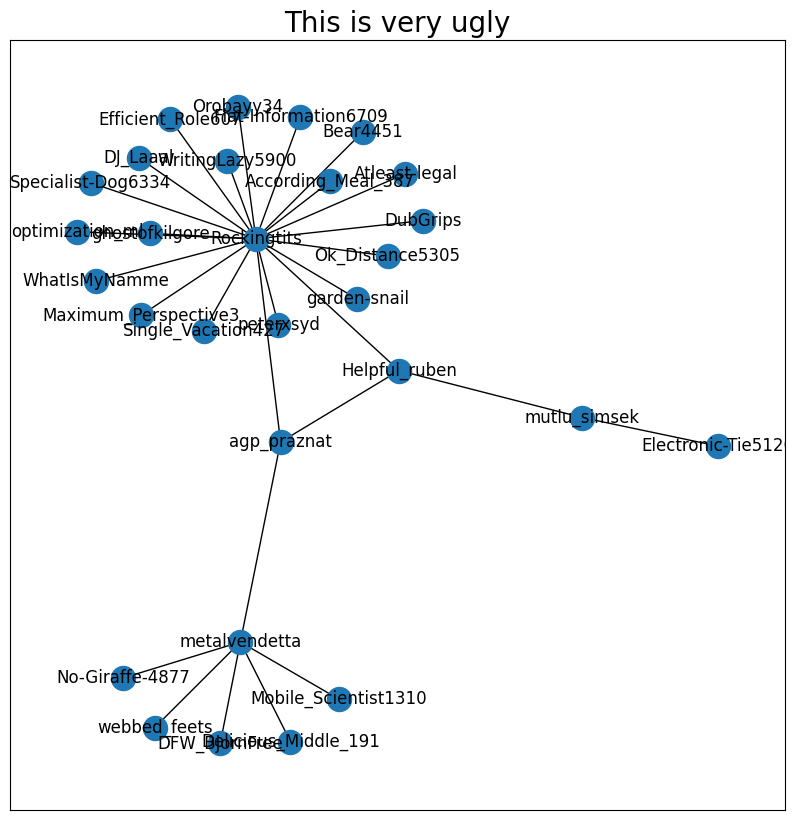

In [69]:
plt.figure(figsize=(10,10))
nx.draw_networkx(GG, pos)
plt.title("This is very ugly", fontsize= 20)

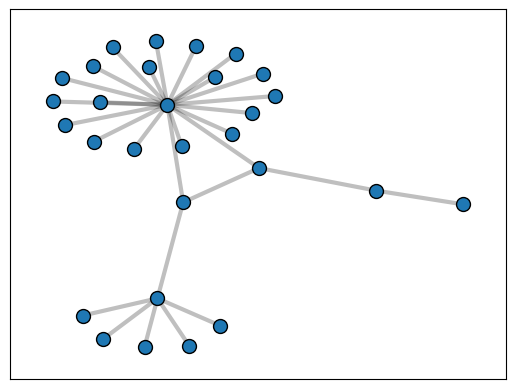

In [70]:
nx.draw_networkx_edges(GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(GG, pos, node_size=100).set_edgecolor('black')

In [ ]:
node_attribute_df.to_csv('node_attribute.csv', index=False)
weighted_EL_df.to_csv('edge_commenting.csv', index=False)

# 2. User similarity networks
The goal of this section is to link users with similar activities. We will then visualize this network. The overall steps are:
- Load the dataframe.
- Construct a bipartite network and project on user side.
- Such projection results in a co-affiliation network.
- Visualize network.

In [71]:
ds_user_submission_df = pd.read_csv(url + "/datascience-user-submission.csv")
ds_user_comment_df = pd.read_csv(url + "/datascience-user-comment.csv")

# ds_user_submission_df = pd.read_csv("./datascience-user-submission.csv")
# ds_user_comment_df = pd.read_csv("./datascience-user-comment.csv")

In [72]:
# Concatenate the DataFrames
ds_user_combined_df = pd.concat([ds_user_submission_df[['user', 'subreddit']],
                                 ds_user_comment_df[['user', 'subreddit']]],
                                 ignore_index=True)

In [73]:
ds_user_combined_df = ds_user_combined_df[ds_user_combined_df['subreddit'] != 'datascience']
ds_user_combined_df

,user,subreddit
0,imoutidi,Tinyman
1,imoutidi,u_imoutidi
2,imoutidi,OnePiece
4,imoutidi,yieldly
5,TheRealBaele,math
...,...,...
574,Ok_Distance5305,learndatascience
575,Ok_Distance5305,Fire
576,i_did_dtascience,buildinpublic
577,i_did_dtascience,GHCWomenInTech


In [74]:
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(ds_user_combined_df['user'], bipartite=0)
B.add_nodes_from(ds_user_combined_df['subreddit'], bipartite=1)
# Add edges between users and subreddits
B.add_edges_from(ds_user_combined_df.itertuples(index=False))

# Project the bipartite graph onto the user nodes
users = ds_user_combined_df['user'].unique()
U_G = bipartite.weighted_projected_graph(B, users)

In [75]:
# Return the largest component
Gcc = sorted(nx.connected_components(U_G), key=len, reverse=True)
U_GG = U_G.subgraph(Gcc[0])

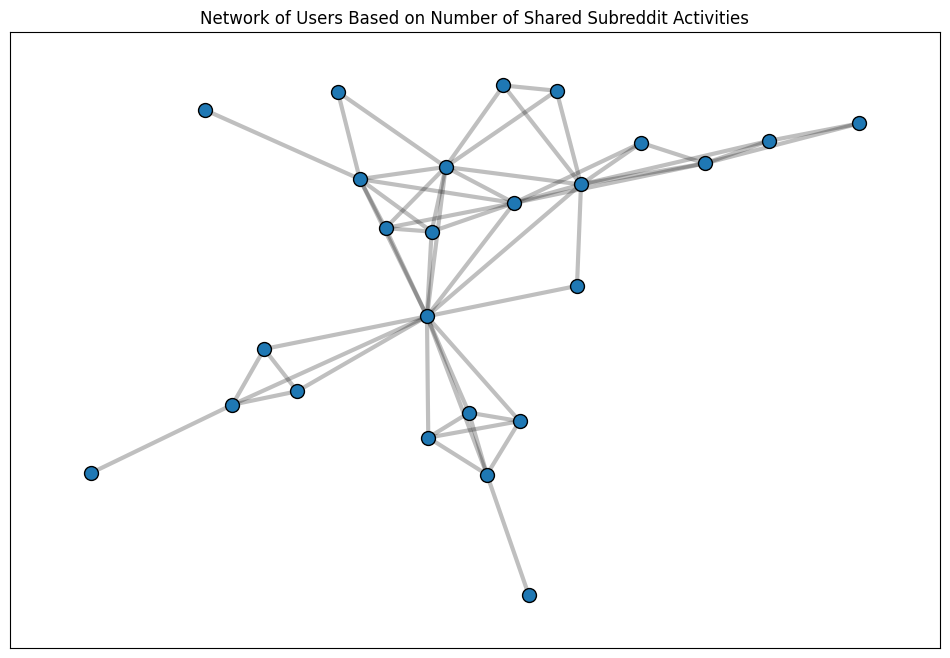

In [76]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(U_GG, weight = 'weight')  # Positioning of nodes
edges = U_GG.edges(data=True)
nx.draw_networkx_edges(U_GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(U_GG, pos, node_size=100).set_edgecolor('black')

# nx.draw_networkx_edge_labels(U_GG, pos, edge_labels={(u, v): str(d["weight"]) for u, v, d in U_GG.edges(data=True)}, font_size=10)
plt.title("Network of Users Based on Number of Shared Subreddit Activities")
plt.show()

In [77]:
# Create a list to store the edges and their weights
edge_list = []
for u, v, data in U_G.edges(data=True):
    edge_list.append([u, v, data['weight']])

# Create a Pandas DataFrame from the edge list
user_graph_edgelist_df = pd.DataFrame(edge_list, columns=['Source', 'Target', 'Weight'])
user_graph_edgelist_df


,Source,Target,Weight
0,imoutidi,TserriednichThe4th,1
1,No-Giraffe-4877,metalvendetta,1
2,No-Giraffe-4877,ThomasAger,1
3,No-Giraffe-4877,koolaidman123,1
4,No-Giraffe-4877,optimization_ml,1
...,...,...,...
59,metalvendetta,According_Meal_387,1
60,ghostofkilgore,DJ_Laaal,1
61,DJ_Laaal,Accurate-Usual8839,1
62,DJ_Laaal,According_Meal_387,1


In [ ]:
user_graph_edgelist_df.to_csv('edge_user_similarity.csv', index=False)

# 3. Subreddit networks

The goal of this subsection is project the bipartite network into subreddit network. We will then visualize this network.

In [78]:
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(ds_user_combined_df['subreddit'], bipartite=0)
B.add_nodes_from(ds_user_combined_df['user'], bipartite=1)
# Add edges between users and subreddits
B.add_edges_from(ds_user_combined_df.itertuples(index=False))

In [79]:
# Project the bipartite graph onto the user nodes
subs = ds_user_combined_df['subreddit'].unique()
S_G = bipartite.weighted_projected_graph(B, subs)

In [80]:
# Return the largest component
Gcc = sorted(nx.connected_components(S_G), key=len, reverse=True)
S_GG = S_G.subgraph(Gcc[0])

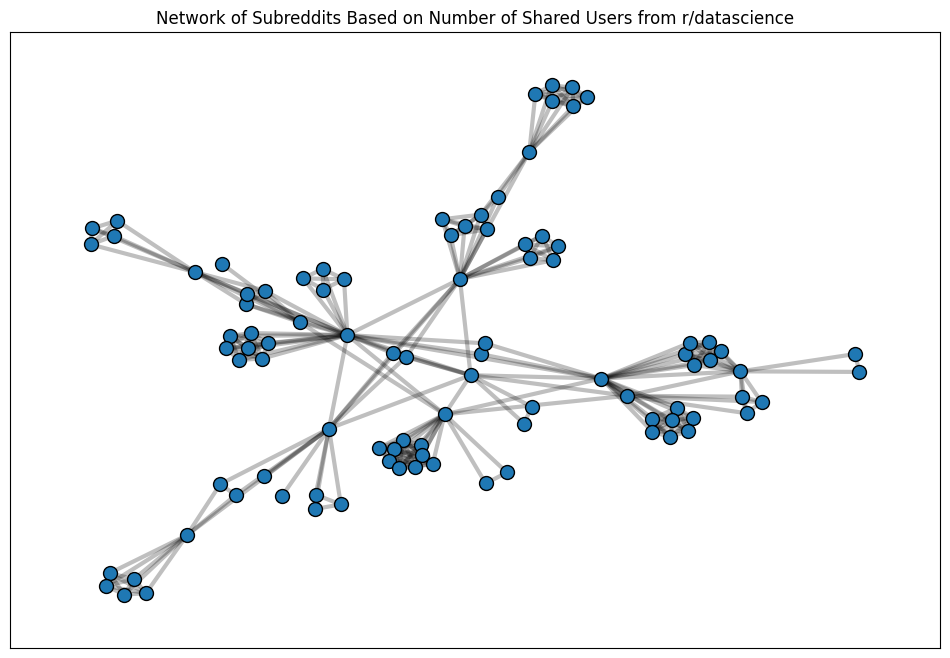

In [81]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(S_GG, weight = 'weight')  # Positioning of nodes
edges = S_GG.edges(data=True)
nx.draw_networkx_edges(S_GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(S_GG, pos, node_size=100).set_edgecolor('black')

# nx.draw_networkx_edge_labels(S_GG, pos, edge_labels={(u, v): str(d["weight"]) for u, v, d in S_GG.edges(data=True)}, font_size=10)
plt.title("Network of Subreddits Based on Number of Shared Users from r/datascience")
plt.show()

The goal of this section is to merge different dataframes of each subreddit, into a network.
We will then visualize this network.
The overall steps are:
- Load the dataframes.
- Make dictionaries {key: value} that contain each subreddit as keys, and the list of unique users as values.
- Generating an edgelist (weighted by number of shared users), then use it to generate a network object.
- Visualize network

### Read dataframe
We will use five files, each of the files has submission(=post) data of each subreddit.

In [83]:
%cd '/content/drive/MyDrive/Tutorial_2'

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Correct the file paths based on where you uploaded files
files = {
    'DS': "/datascience-new-submission-for-subreddit-network.csv",
    'ML': "/MachineLearning-new-submission-for-subreddit-network.csv",
    'Data': "/datasets-new-submission-for-subreddit-network.csv",
    'Viz': "/dataisbeautiful-new-submission-for-subreddit-network.csv",
    'Py': "/learnpython-new-submission-for-subreddit-network.csv",
}

/content/drive/MyDrive/Tutorial_2


From the files, we can make a dictionary that contains keys as each subreddits, and values as unique users of each subreddits.

In [84]:
# Extract unique authors from each file
unique_authors = {file_name: pd.read_csv(url + file_path)['author'].unique().tolist() for file_name, file_path in files.items()}
unique_authors['DS'][:10]

['ciaoshescu',
 'ButtFlannel69',
 'ThomasAger',
 'Factitious_Character',
 'bingbong_sempai',
 'samushusband',
 'AutoModerator',
 'mutlu_simsek',
 'metalvendetta',
 'Rockingtits']

In [85]:
intersection = set(unique_authors['DS']).intersection(set(unique_authors['ML']))

# Print the intersection
print(intersection)


{'titiboa', 'metalvendetta', 'RobertWF_47', 'mgalarny', 'FreakedoutNeurotic98', 'AdministrativeRub484', 'WristbandYang', 'Daniel-Warfield', 'Mission-Balance-4250', 'AutoModerator'}


After we make that dictionary, we make multiple pairwise comparisons, and count the number of shared users to make an edgelist. For example, if a user A posted on both r/Python and r/rprogramming, we add 1 to the weight of the link between Python and R.

In [86]:
# Recreate the edge list dataframe
edge_list_data = []

for file_1 in unique_authors.keys():
    for file_2 in unique_authors.keys():
        if file_1 != file_2:
            # Calculate intersection of authors
            common_authors = set(unique_authors[file_1]).intersection(set(unique_authors[file_2]))
            if common_authors:
                edge_list_data.append([file_1, file_2, len(common_authors)])



In [87]:
# Convert the edge list data to a dataframe
edge_list_df = pd.DataFrame(edge_list_data, columns=['Source', 'Target', 'Weight'])
edge_list_df

,Source,Target,Weight
0,DS,ML,10
1,DS,Data,7
2,DS,Viz,6
3,DS,Py,2
4,ML,DS,10
5,ML,Data,10
6,ML,Viz,5
7,ML,Py,1
8,Data,DS,7
9,Data,ML,10


Let's visualize it in a simple way.

In [88]:
G = nx.from_pandas_edgelist(edge_list_df, 'Source', 'Target', edge_attr='Weight', create_using=nx.Graph())

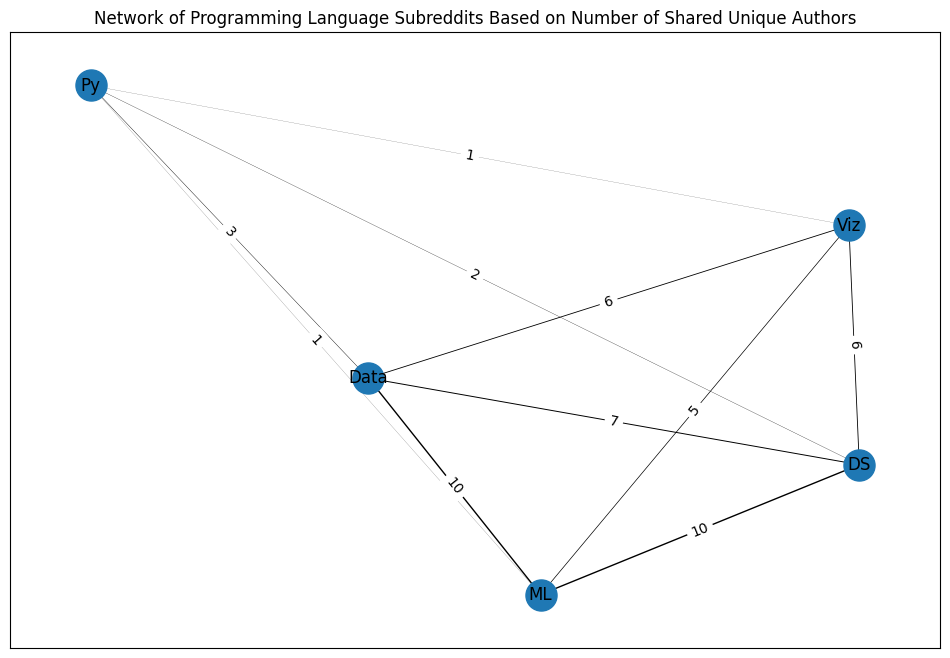

In [ ]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, weight = 'Weight')  # Positioning of nodes
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[edata['Weight'] * 0.1 for _, _, edata in edges])
nx.draw_networkx_labels(G, pos, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): str(d["Weight"]) for u, v, d in G.edges(data=True)}, font_size=10)
plt.title("Network of Programming Language Subreddits Based on Number of Shared Unique Authors")
plt.show()

Of course, the result is same even if you use the bipartite network projection.

In [89]:
# Create an empty list to store the data for the new DataFrame
new_df_data = []

# Iterate through the files dictionary
for name, file_path in files.items():
  # For each subreddit, create a list of dictionaries with 'subreddit' and 'author' columns
  for author in unique_authors[name]:
    new_df_data.append({'subreddit': name, 'author': author})

# Create the new DataFrame from the list of dictionaries
new_df = pd.DataFrame(new_df_data)
print(new_df)


     subreddit                author
0           DS            ciaoshescu
1           DS         ButtFlannel69
2           DS            ThomasAger
3           DS  Factitious_Character
4           DS       bingbong_sempai
...        ...                   ...
3258        Py     Frosty-Finish4724
3259        Py            Asome10121
3260        Py            jr-jarrett
3261        Py       Hot_Radish_9896
3262        Py            VonRoderik

[3263 rows x 2 columns]


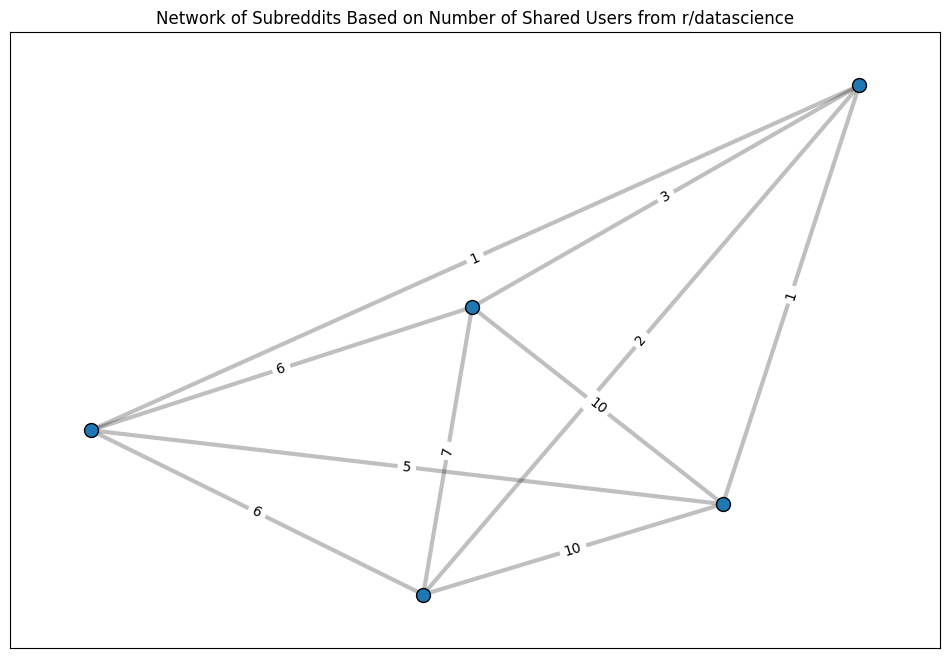

In [90]:
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(new_df['subreddit'], bipartite=0)
B.add_nodes_from(new_df['author'], bipartite=1)
# Add edges between users and subreddits
B.add_edges_from(new_df.itertuples(index=False))

# Project the bipartite graph onto the user nodes
subs = new_df['subreddit'].unique()
S_G = bipartite.weighted_projected_graph(B, subs)

# Return the largest component
Gcc = sorted(nx.connected_components(S_G), key=len, reverse=True)
S_GG = S_G.subgraph(Gcc[0])

# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(S_GG, weight = 'weight')  # Positioning of nodes
edges = S_GG.edges(data=True)
nx.draw_networkx_edges(S_GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(S_GG, pos, node_size=100).set_edgecolor('black')

nx.draw_networkx_edge_labels(S_GG, pos, edge_labels={(u, v): str(d["weight"]) for u, v, d in S_GG.edges(data=True)}, font_size=10)
plt.title("Network of Subreddits Based on Number of Shared Users from r/datascience")
plt.show()

# On your own
3.1. With csv files that you scraped with Reddit Scraper, make 3 types of networks (user interaction, user similarity, subreddit similarity) and visualize them.  
3.2. Visualize user interaction data with Gephi.